In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

% matplotlib inline

INPUT_PATH = "data/2/{}_2014-2017.csv"


/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Output graphs 

In [90]:
def PolynomialRidge(X, y, degrees, alpha, use_scaler):
    reg = LinearRegression()
    res_cv = {}
    res_train = {}
    for degree in degrees:
        print("Working on degree", degree)
    
        # transforms the data to polynomials
        if use_scaler:
            est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=alpha))
        else:
            est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
        est.fit(X, y)

        # calculates the MSE for CV
        scores = cross_val_score(est, X, y, cv=3, scoring='neg_mean_squared_error') # cross val
        res_cv[degree] = np.mean(-scores)
        
        print("std", np.std(-scores))
    
        # calculates the MSE for Training Set
        est.fit(X,y)
        y_pred = est.predict(X)
        res_train[degree] = np.sum((y_pred-y)**2)/len(y)
    
    return res_train, res_cv    

def plot_against_baseline(res_model, res_fp, res_mean):
    degrees = list(res_model.keys())
    mse_model = list(res_model.values())
    mse_fp = list(res_fp.values())
    mse_mean = list(res_fp.values())

    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    plt.plot(degrees,mse_model)
    plt.plot(degrees,mse_mean)
    plt.plot(degrees,mse_fp)
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('Normal Scale')
    plt.legend(['Model', 'Mean FP', 'Previous FP'])

    plt.subplot(1,2,2)
    plt.semilogy(degrees,mse_model)
    plt.semilogy(degrees,mse_mean)
    plt.semilogy(degrees,mse_fp)
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('Log Scale')

    loc = np.argmin(list(res_cv.values()))
    print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])
    
def get_df(features):
    RB = pd.read_csv(INPUT_PATH.format("RB"))[['next_fp'] + features]
    RB['WR'] = 0
    WR = pd.read_csv(INPUT_PATH.format("WR"))[['next_fp']+ features]
    WR['WR'] = 1
    return pd.concat([RB, WR])

def plot_by_degree(res_train, res_cv):
    degrees = list(res_cv.keys())
    mse_cv = list(res_cv.values())
    mse_train = list(res_train.values())

    fig = plt.figure(figsize=[15,5])
    ax1 = fig.add_subplot(121)
    #plt.subplot(1,2,1)
    #ax1.plot(degrees,mse_cv)
    #ax1.plot(degrees,mse_train)
    plt1, = plt.plot(degrees,mse_cv)
    plt2, = plt.plot(degrees,mse_train)
    ax1.set_title('Normal Scale', fontsize=20)
    
    '''
    ax3 = fig.add_subplot(122)
    plt.semilogy(degrees,mse_cv)
    plt.semilogy(degrees,mse_train)
    plt.xlabel('Degree', fontsize=16)
    #plt.ylabel('MSE', fontsize=16)
    ax3.set_title('Log Scale', fontsize=20)
    '''
    
    ax4 = ax1.twinx()
    ax4.set_yticks(np.sqrt([33, 34, 35, 36, 37, 38]))
    ax4.set_ylabel('sqrt(MSE)', fontsize = 14)        
    ax4.set_ylim([np.sqrt(min(mse_train)), np.sqrt(max(mse_train))])
    
    ax1.set_xlabel('Degree', fontsize=14)
    ax1.set_ylabel('MSE', fontsize=14)
    plt.legend([plt1, plt2], ['CV','Train'], fontsize=14)

    loc = np.argmin(list(res_cv.values()))
    print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

In [3]:
features = ['status_code', 'week', 'afc_s', 'rush_att', 'rec_target', 'fp', 'temperature', 'rec_td']  # WR
df = get_df(features)
df.head()

,next_fp,status_code,week,afc_s,rush_att,rec_target,fp,temperature,rec_td,WR
0,19.4,0.0,4,0.0,13.0,0.0,10.9,88,0.0,0
1,4.2,0.0,5,0.0,19.0,1.0,19.4,70,0.0,0
2,19.8,0.0,6,0.0,13.0,4.0,4.2,51,0.0,0
3,5.1,0.0,6,0.0,10.0,3.0,3.1,51,0.0,0
4,8.0,0.0,7,0.0,17.0,5.0,19.8,28,0.0,0


Working on degree 0
std 6.287367204411885
The degree 0 had an MSE of: 37.73475092440445


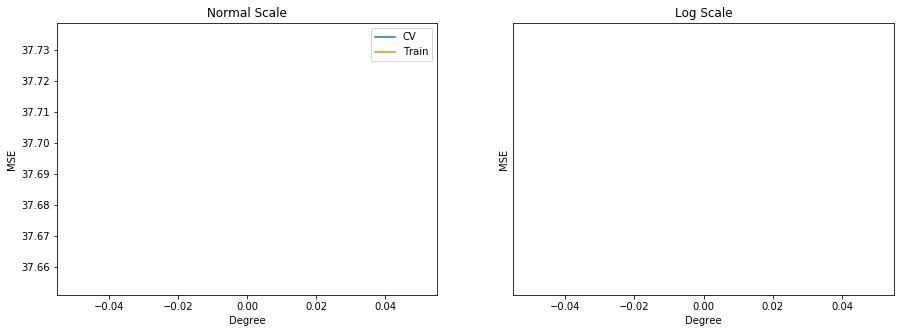

In [181]:
ym = df['next_fp']
Xm = pd.DataFrame([9.844444444444445]*len(df))
res_train_m, res_cv_m = PolynomialRidge(Xm, ym, [0], 75, True)
plot_by_degree(res_train_m, res_cv_m)

0.0368439324133405
Working on degree 0
std 6.287367204411885
Working on degree 1
std 5.028745410040412
Working on degree 2
std 5.029133151206842
Working on degree 3
std 5.035257118548449
The degree 1 had an MSE of: 36.539887307409366


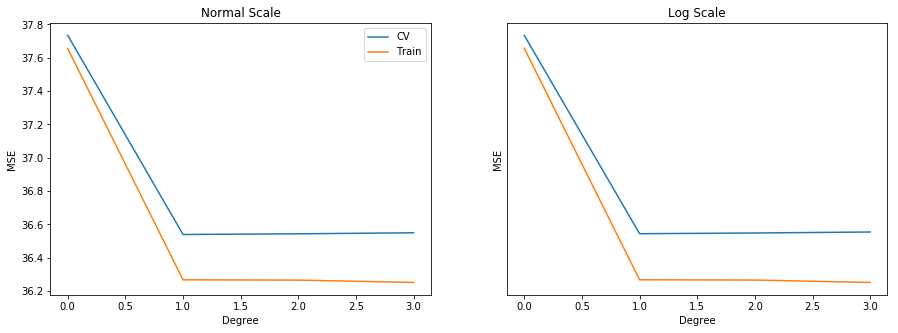

In [182]:
yf = df['next_fp']
Xf = df[['fp']]

# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df[['fp']]
# Choose the response variable(s)
y = df['next_fp'].values
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))

res_train_fp, res_cv_fp = PolynomialRidge(Xf, yf, [0, 1, 2, 3], 75, True)

plot_by_degree(res_train_fp, res_cv_fp)

Working on degree 0
std 6.287367204411885
Working on degree 1
std 4.497908796267427
Working on degree 2
std 4.579235391109585
Working on degree 3
std 4.895141769678373
The degree 1 had an MSE of: 34.97883102040959


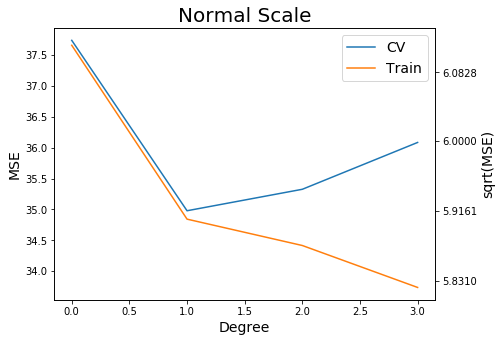

In [91]:
y1 = df['next_fp']
X1 = df[features + ['WR']]
res_train, res_cv = PolynomialRidge(X1, y1, [0, 1, 2, 3], 75, True)


plot_by_degree(res_train, res_cv)



In [173]:
def get_model_scores(X, y, cv=5):
    #reg = make_pipeline(PolynomialFeatures(1), StandardScaler(), Ridge(alpha=75))
    # 10-fold cross-validation with our training data
    #reg = make_pipeline(pipeline)
    reg = make_pipeline(LinearRegression())
    r2_scores = cross_val_score(reg, X, y, cv=cv, scoring='r2')

    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print('-----------------------')
    print('Rˆ2 for each cross-val:',r2_scores,'\n')
    print('Mean Rˆ2 of all cross vals:',np.mean(r2_scores),'+-',np.std(r2_scores))

    mse_scores = cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')

    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print('Mean for each cross-val:',-mse_scores,'\n')
    print('Mean of all cross vals:',np.mean(-mse_scores),'+-',np.std(-mse_scores))
    print('-----------------------')
    return (r2_scores, np.std(r2_scores)), (-mse_scores, np.std(-mse_scores))

# get_model_scores(X, y) # normalize, linear reg

df = df.sort_values(by=["name", "season", "week"])
#df_ap = df[(df['name'] == 'Adrian Peterson') & (df['season'] == 2015)]
df['mean'] = df['fp'].mean()
sim_y = df.next_fp

get_model_scores(df[['mean']], sim_y)
get_model_scores(df[['fp']], sim_y)


-----------------------
Rˆ2 for each cross-val: [-0.01639137 -0.01228115 -0.00670588 -0.06532561 -0.04183821] 

Mean Rˆ2 of all cross vals: -0.02850844319770185 +- 0.02199402882656566
Mean for each cross-val: [39.24854839 50.72418508 40.79484502 52.90978189 40.04955949] 

Mean of all cross vals: 44.74538397586615 +- 5.835686471318407
-----------------------
-----------------------
Rˆ2 for each cross-val: [0.01549409 0.09622055 0.03756038 0.01682827 0.02293353] 

Mean Rˆ2 of all cross vals: 0.03780736110407583 +- 0.030237052674257917
Mean for each cross-val: [38.01727275 45.28729617 39.00103897 48.82957992 37.55965329] 

Mean of all cross vals: 41.73896822249189 +- 4.509575424384673
-----------------------


((array([0.01549409, 0.09622055, 0.03756038, 0.01682827, 0.02293353]),
  0.030237052674257917),
 (array([38.01727275, 45.28729617, 39.00103897, 48.82957992, 37.55965329]),
  4.509575424384673))

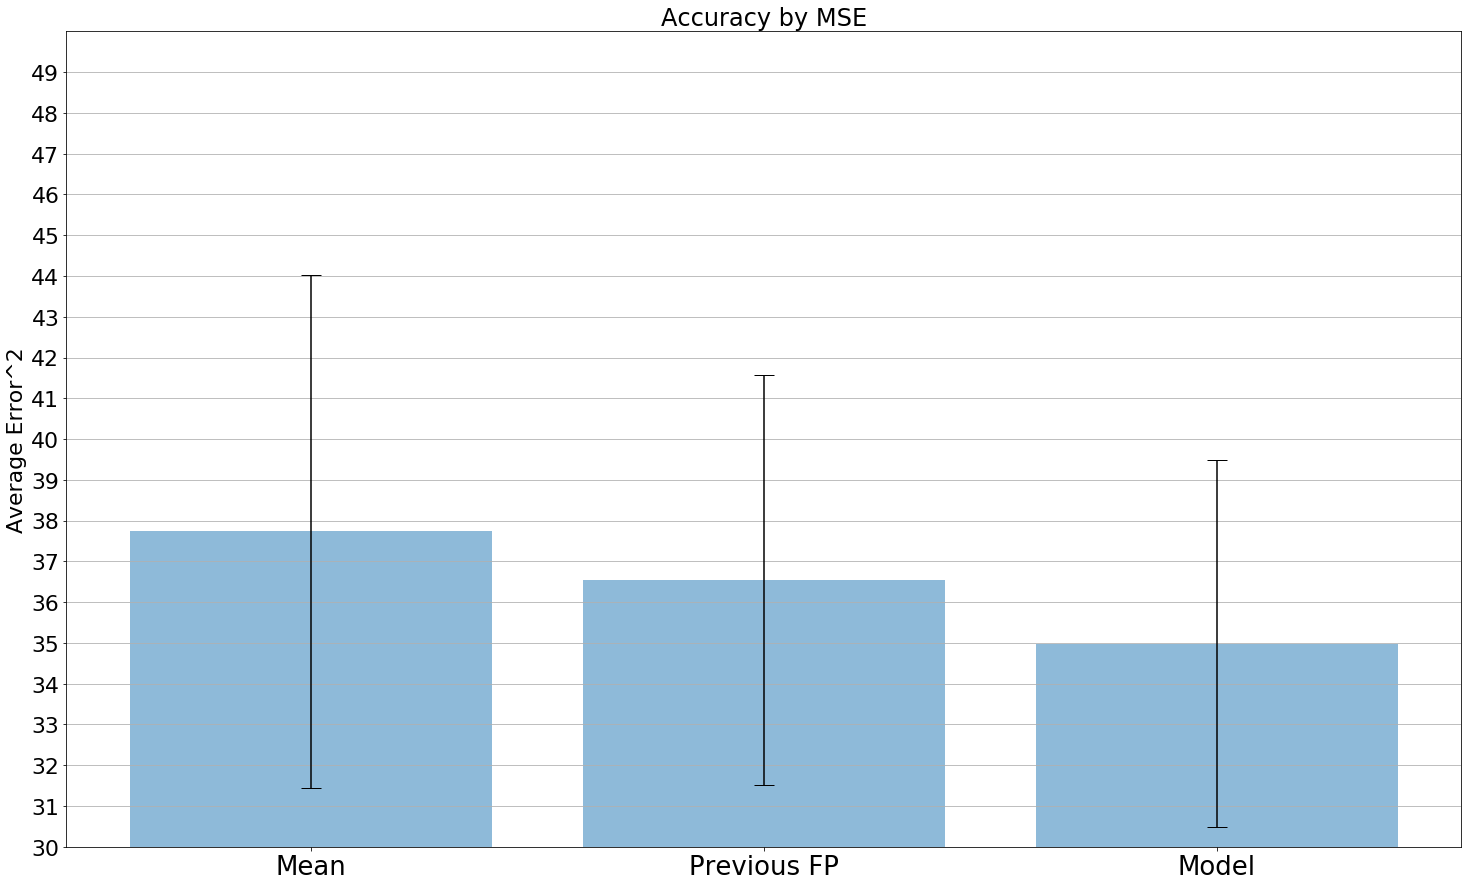

In [202]:


labels = ['Mean', 'Previous FP', 'Model']
x_pos = np.arange(len(labels))
CTEs = [37.73475092440445, 36.539887307409366, 34.97883102040959]
error = [6.287367204411885, 5.028745410040412, 4.497908796267425]

plt.figure(figsize=[25, 15])
ax = plt.subplot(1, 1, 1)
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Error^2', fontsize = 22)
ax.set_yticks(np.arange(30, 50))
ax.set_ylim([30, 50])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=26)
plt.yticks(fontsize=22)
ax.set_title('Accuracy by MSE', fontsize=24)
ax.yaxis.grid(True)

plt.show()

In [86]:
df = pd.read_csv("data/2/RB_2014-2017.csv")
df.describe()

,Unnamed: 0,rush_att,rush_yd,rush_td,rec_target,rec_rec,rec_yd,rec_td,fp,season,...,afc_w,nfc_e,nfc_n,nfc_s,nfc_w,temperature,wind,precipitation,dome,status_code
count,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,...,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000
mean,1596.000000,11.957094,51.870968,0.379894,3.327592,2.538365,21.797996,0.120576,10.369715,2015.527091,...,0.119010,0.134043,0.124334,0.129972,0.113686,61.454118,2.885061,0.050423,0.188224,0.117444
std,921.884031,7.098288,37.287597,0.626830,2.591879,2.107508,22.211593,0.342562,6.651304,1.129174,...,0.323851,0.340752,0.330014,0.336325,0.317479,15.709251,2.716607,0.218850,0.390952,0.322000
min,0.000000,0.000000,-8.000000,0.000000,0.000000,0.000000,-8.000000,0.000000,1.300000,2014.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,798.000000,6.000000,25.000000,0.000000,1.000000,1.000000,4.000000,0.000000,5.300000,2014.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000
50%,1596.000000,11.000000,45.000000,0.000000,3.000000,2.000000,16.000000,0.000000,8.500000,2016.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,2.000000,0.000000,0.000000,0.000000
75%,2394.000000,17.000000,71.000000,1.000000,5.000000,4.000000,32.000000,0.000000,13.800000,2017.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,5.000000,0.000000,0.000000,0.000000
max,3192.000000,38.000000,236.000000,4.000000,14.000000,12.000000,159.000000,3.000000,47.800000,2017.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,92.000000,9.000000,1.000000,1.000000,1.000000


In [93]:
df = df.sort_values(by=["name", "season", "week"])
sim_y = df[(df['name'] == 'Adrian Peterson') & (df['season'] == 2015)].fp

In [162]:
import random

fp_res = np.sqrt(36.5)
m_res = np.sqrt(34.97)

y = sim_y
#y = list(df.fp.iloc[:17].values)
#y.append(df.fp.min())
#random.shuffle(y)

y_fph = [i + fp_res for i in y]
y_fpl = [i - fp_res for i in y]

y_mh = [i + m_res for i in y]
y_ml = [i - m_res for i in y]

y_meh = [i + 7.927 for i in y]
y_mel = [i - 7.927 for i in y]

In [161]:
print(fp_res, m_res)
print(np.mean(sim_y))
print(np.sqrt(62.83733127572017))

6.041522986797286 5.913543776789007
9.844444444444445
7.927000143542333


Working on degree 0
Working on degree 1
Working on degree 2
The degree 0 had an MSE of: 62.83733127572017


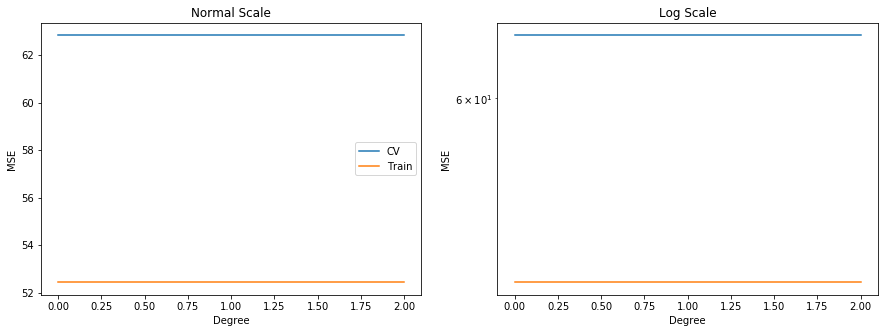

In [160]:
ym = df[(df['name'] == 'Adrian Peterson') & (df['season'] == 2015)].sort_values(by=['season', 'week']).next_fp
Xm = pd.DataFrame([9.844444444444445]*len(ym))
res_train_m, res_cv_m = PolynomialRidge(Xm, ym, [0, 1, 2], 75, True)
plot_by_degree(res_train_m, res_cv_m)

"\nplt.subplot(1,2,2)\nplt.semilogy(x,y, color = 'k')\nplt.plot(x,y_fph, color = 'r')\nplt.plot(x,y_fpl, color = 'r')\nplt.plot(x,y_mh, color = 'b')\nplt.plot(x,y_ml, color = 'b')\nplt.xlabel('Week')\nplt.ylabel('MSE')\nplt.title('Log Scale')\n"

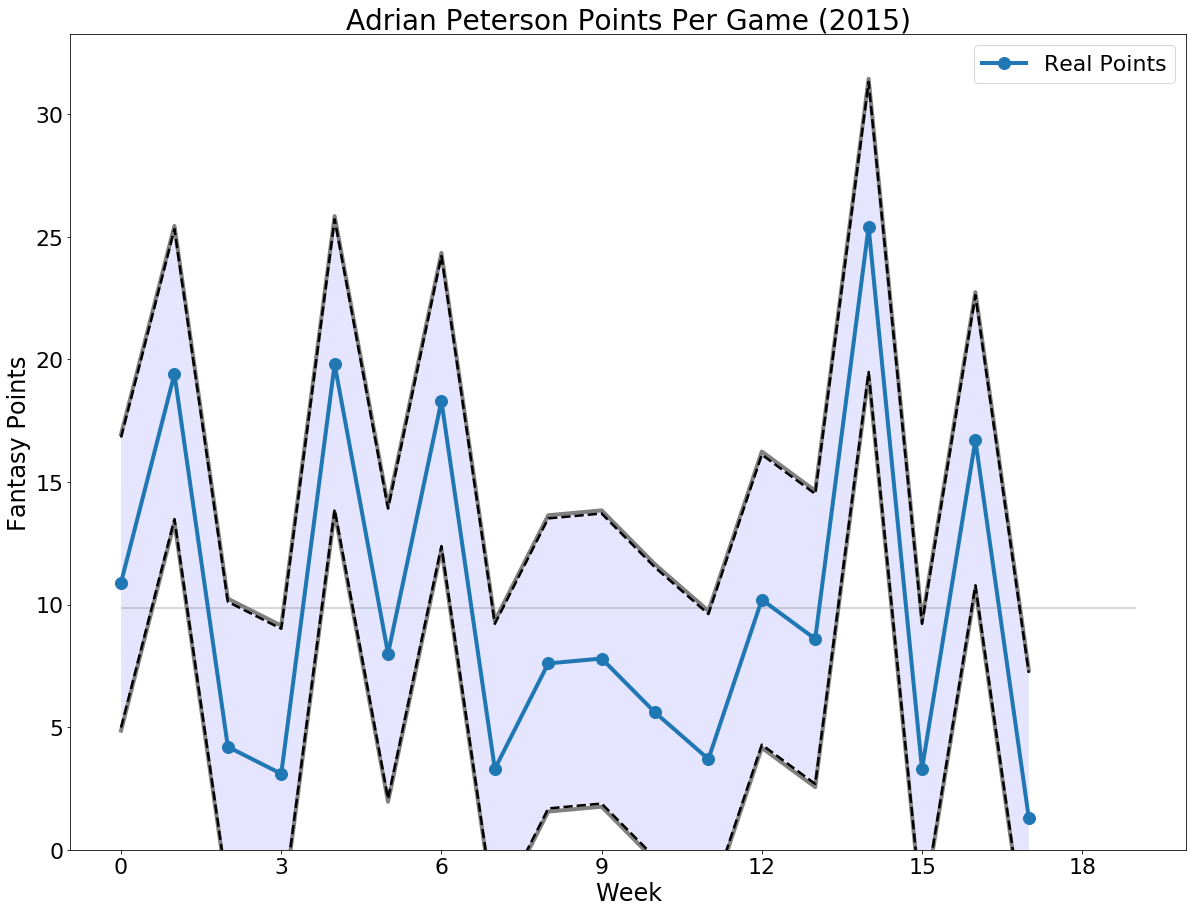

In [164]:
from matplotlib.ticker import MaxNLocator

x = range(len(sim_y))
#sim_y = y
ax = plt.figure(figsize=[20,15]).gca()
#plt.subplot(1,2,1)
plt.plot(x,y, '-o', markersize=12, linewidth=4)
plt.plot(x,y_fph, color = 'grey', linewidth = 4)
plt.plot(x,y_fpl, color = 'grey', linewidth = 4)
plt.plot(x,y_mh, color = 'k',linestyle='--', linewidth = 2.5)
plt.plot(x,y_ml, color = 'k',linestyle='--', linewidth = 2.5)
#plt.plot(x,y_mh, color = 'grey',linewidth = 2)
#plt.plot(x,y_ml, color = 'grey',linewidth = 2)
plt.hlines(np.mean(y), xmin=0, xmax=19, color='grey', alpha=0.3, linewidth=2)

plt.xticks(fontsize=22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.fill_between(x, y_fph, y_ml, alpha=0.1, facecolor='blue')
#plt.xticks(range(1, 19))
plt.yticks(fontsize=22)
plt.ylim(ymin=0)
plt.xlabel('Week', fontsize=24)
plt.ylabel('Fantasy Points', fontsize=24)
plt.legend(['Real Points'], fontsize=22)
plt.title('Adrian Peterson Points Per Game (2015)', fontsize=28)
'''
plt.subplot(1,2,2)
plt.semilogy(x,y, color = 'k')
plt.plot(x,y_fph, color = 'r')
plt.plot(x,y_fpl, color = 'r')
plt.plot(x,y_mh, color = 'b')
plt.plot(x,y_ml, color = 'b')
plt.xlabel('Week')
plt.ylabel('MSE')
plt.title('Log Scale')
'''